<a href="https://colab.research.google.com/github/jrgosalvez/data255_DL/blob/main/HW9-Transformers/Jorge_Gosalvez_255_HW9_trans_en_de_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SJSU MSDS 255 DL, Spring 2024 - Transformers
Homework 09: Transformer for English to German Translation Pytorch Tutorial

Git: https://github.com/jrgosalvez/data255_DL

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

Language Translation with `nn.Transformer` and torchtext
========================================================

Experiment:
-   Train a translation model from scratch using Transformer.
-   Use torchtext library to access [Multi30k](http://www.statmt.org/wmt16/multimodal-task.html#task1) dataset to train a English to German translation model.



References:
- [Attention is all you need paper](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf)
- [The annotated transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding)
- [Tensorflow/Keras Tutorial](https://www.tensorflow.org/text/tutorials/transformer)
- [German to English Tutorial in pytorch](https://github.com/jrgosalvez/data255_DL/blob/main/HW9-Transformers/Jorge_Gosalvez_255_HW9_trans_de_en_Pytorch.ipynb)


Data Sourcing and Processing
============================

In [2]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k
from typing import Iterable, List


# We need to modify the URLs for the dataset since the links to the original dataset are broken
# Refer to https://github.com/pytorch/text/issues/1756#issuecomment-1163664163 for more info
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"

# Set source and target languages (e.g. from:to)
SRC_LANGUAGE = 'en'
TGT_LANGUAGE = 'de'

# Place-holders
token_transform = {}
vocab_transform = {}

*Install torchdata and spacy*, then *reset kernel* (Jupyter) or runtime (Colab) and *skip this step by commenting out the cell* in the next run.

In [5]:
!pip install -U torchdata
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 46.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
  Using cached https://github.com/explosion/spacy-models/releases/download/de_core_news_sm-3.7.0/de_core_news_sm-3.7.0-py3-none-any.whl (14.6 MB)
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


**Restart the kernel (Jupyter) or runtime (Colab)**

In [ ]:
import os
os.kill(os.getpid(), 9)

**Re-import libraries except torchdata and spacy, then skip back to this install of portallocker step after reimporting everything but the torchdata and spacy**

In [3]:
!pip install portalocker>=2.0.0

In [4]:
# set SRC as en and TGT as de
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')


# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

"""
Purpose: Defines special tokens used in the vocabulary for machine learning tasks with text data.
Special Tokens:
<unk>: "Unknown" token (represents words not in the vocabulary)
<pad>: Padding token (to make sequences the same length)
<bos>: "Beginning of Sequence"
<eos>: "End of Sequence"
"""

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set ``UNK_IDX`` as the default index. This index is returned when the token is not found.
# If not set, it throws ``RuntimeError`` when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

<table>
<tr>
  <th colspan=1>The original Transformer diagram</th>
  <th colspan=1>A representation of a 4-layer Transformer</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
  <td>
   <img width=307 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
</table>

Seq2Seq Network using Transformer
=================================

In [5]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [6]:
# use word mask to stop model from looking forward during predictions
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

# use mask to hide source and target padding tokens
def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [7]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

# define loss function (b/c vector of n numbers; stack of linear activation functions) and optimizer
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

Collation
=========


In [8]:
# Convert string pairs into the batched tensors that can be processed by `Seq2Seq` network

from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# ``src`` and ``tgt`` language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate batch of raw strings data samples into batch tensors to feed the model
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [9]:
# define train and eval loop
from torch.utils.data import DataLoader

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(list(train_dataloader))


def evaluate(model):
    model.eval()
    losses = 0

    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))

In [10]:
# train model

from timeit import default_timer as timer
NUM_EPOCHS = 25

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))


# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

Epoch: 1, Train loss: 5.901, Val loss: 4.637, Epoch time = 30.571s
Epoch: 2, Train loss: 4.127, Val loss: 3.766, Epoch time = 34.878s
Epoch: 3, Train loss: 3.458, Val loss: 3.314, Epoch time = 23.917s
Epoch: 4, Train loss: 3.022, Val loss: 3.005, Epoch time = 23.978s
Epoch: 5, Train loss: 2.700, Val loss: 2.809, Epoch time = 32.742s
Epoch: 6, Train loss: 2.442, Val loss: 2.642, Epoch time = 27.605s
Epoch: 7, Train loss: 2.233, Val loss: 2.506, Epoch time = 26.006s
Epoch: 8, Train loss: 2.055, Val loss: 2.384, Epoch time = 26.297s
Epoch: 9, Train loss: 1.906, Val loss: 2.290, Epoch time = 28.194s
Epoch: 10, Train loss: 1.771, Val loss: 2.236, Epoch time = 24.018s
Epoch: 11, Train loss: 1.652, Val loss: 2.207, Epoch time = 24.559s
Epoch: 12, Train loss: 1.549, Val loss: 2.178, Epoch time = 27.523s
Epoch: 13, Train loss: 1.451, Val loss: 2.152, Epoch time = 29.832s
Epoch: 14, Train loss: 1.361, Val loss: 2.102, Epoch time = 31.129s
Epoch: 15, Train loss: 1.280, Val loss: 2.069, Epoch time

Run below for 18 epochs, skip if 25

In [11]:
# test the 18 epoch model using inverse of tutorial
print(translate(transformer, "A group of people stand in front of an igloo."))    # Eine Gruppe von Menschen steht vor einem Iglu

# test a couple and compare to Google Translate
print(translate(transformer, "Bananas are good, but fried plantains are yummy.")) # Bananen sind gut, aber frittierte Kochbananen sind lecker
print(translate(transformer, "Data do. Data don't. Data here. Data there. Data everywhere.")) # Daten schon. Daten nicht. Daten hier. Daten da. Überall Daten.

 Eine Gruppe von Personen steht vor einem Iglu . 
 Die neue einander , aber alle in London Kleidung tragen . 
 Ein Friseur macht die Aufmerksamkeit der Startlinie , dass es nicht ich alle Zeit mit Kameras . 


Run below for 25 epochs, or run the above for 18 epochs

In [11]:
# test the 25 epoch model using inverse of tutorial
print(translate(transformer, "A group of people stand in front of an igloo."))    # Eine Gruppe von Menschen steht vor einem Iglu

# test a couple and compare to Google Translate
print(translate(transformer, "Bananas are good, but fried plantains are yummy.")) # Bananen sind gut, aber frittierte Kochbananen sind lecker
print(translate(transformer, "Data do. Data don't. Data here. Data there. Data everywhere.")) # Daten schon. Daten nicht. Daten hier. Daten da. Überall Daten.

 Eine Gruppe von Personen steht vor einem Iglu . 
 Rettungsschwimmer sind alle in unterschiedlichen Sportkleidung , wahrscheinlich . 
 Ein Friseur macht mit der Aufschrift „ Grand Anschauen of America . 


### BLUE Score

In [12]:
# BLUE score function and plot function
import nltk
import matplotlib.pyplot as plt

def compute_bleu_score(candidate, reference):
    """
    Computes BLEU score using NLTK.

    Args:
    candidate (str): Candidate translation.
    reference (str): Reference translation.

    Returns:
    float: BLEU score.
    """
    return nltk.translate.bleu_score.sentence_bleu([reference], candidate)

def plot_bleu_scores(candidate_translations, reference_translations):
    """
    Plots BLEU scores for a set of translations.

    Args:
    candidate_translations (list): List of candidate translations.
    reference_translations (list): List of reference translations.
    """
    bleu_scores = [compute_bleu_score(candidate, reference) for candidate, reference in zip(candidate_translations, reference_translations)]
    plt.plot(bleu_scores)
    plt.xlabel('Sentence')
    plt.ylabel('BLEU Score')
    plt.title('BLEU Scores for Transformer Model')
    plt.show()

In [16]:
# Translations
"""
candidate_translations = generated by model
reference_translations = human translations; or in our case Google Translate
"""

reference_translations    = ["Eine Gruppe von Menschen steht vor einem Iglu", "Bananen sind gut, aber frittierte Kochbananen sind lecker", "Daten schon. Daten nicht. Daten hier. Daten da. Überall Daten."]

# 18 Epoch
candidate_translations_18 = ["Eine Gruppe von Personen steht vor einem Iglu", "Die neue einander , aber alle in London Kleidung tragen", "Ein Friseur macht die Aufmerksamkeit der Startlinie , dass es nicht ich alle Zeit mit Kameras"]
# 25 Epoch
candidate_translations_25 = ["Eine Gruppe von Personen steht vor einem Iglu", "Rettungsschwimmer sind alle in unterschiedlichen Sportkleidung , wahrscheinlich", "Ein Friseur macht mit der Aufschrift „ Grand Anschauen of America"]

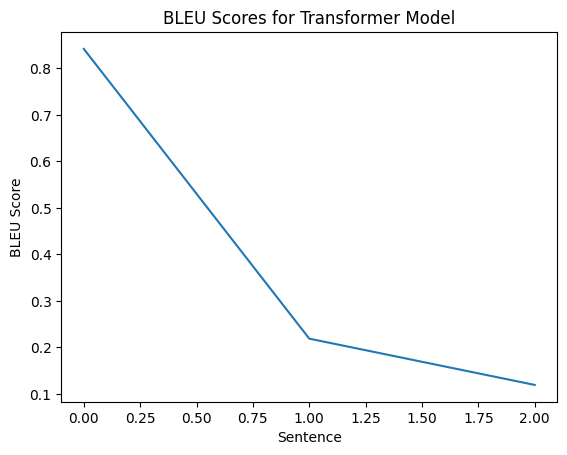

In [14]:
plot_bleu_scores(candidate_translations_18, reference_translations)

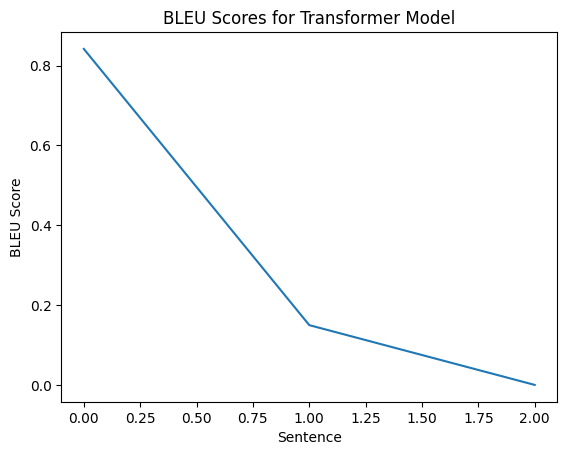

In [17]:
plot_bleu_scores(candidate_translations_25, reference_translations)

## Analysis (18 epochs vs 25 epochs)

In both training runs the transformer model did not generalize well and therefore needs improvement.

**Results of transformer training runs**
Epoch: 18, Train loss: 1.076, Val loss: 2.031, Epoch time = 24.183s

The Transformer German to English and English to German performed as expected; however, new phrases did not match what Google translate produced.

---

Epoch: 25, Train loss: 0.707, Val loss: 2.063, Epoch time = 24.200s

The training loss continued to improve with training; however, the new phrases still did not match what Google translate produced.

That said, responses of the 18 epoch training session were incoherent, whereas the 25 epochs although not accurate, were coherent.

---

Checking the results of the Transformer in Google, here are the English translations:
- **Provided**: A group of people stand in front of an igloo.
- **Translated**: Eine Gruppe von Personen steht vor einem Iglu. [*matches the tutorial*]
- **Google Translate**: A group of people stand in front of an igloo. [*matches Google Translate*]
- Transformer answers match eachother.


---

- **Provided**: Bananas are good, but fried plantains are yummy.
- **18 Epoch Translated**:  Die neue einander , aber alle in London Kleidung tragen.
- **18 Epoch Google Translate**: The new each other, but everyone in London wears clothes. [*does not match Google Translate*]
- **25 Epoch Translated**:   Rettungsschwimmer sind alle in unterschiedlichen Sportkleidung , wahrscheinlich.
- **25 Epoch Google Translate**: Lifeguards are all dressed in different sportswear, probably. [*does not match Google Translate*]
- Transformer answers to not match eachother either.


---



- **Provided**: Data do. Data don't. Data here. Data there. Data everywhere.
- **18 Epoch Translated**: in Friseur macht die Aufmerksamkeit der Startlinie , dass es nicht ich alle Zeit mit Kameras.
- **18 Epoch Google Translate**: A hairdresser draws attention to the starting line so that it's not me all the time with cameras. [*does not match Google Translate*]
- **25 Epoch Translated**: Ein Friseur macht mit der Aufschrift „ Grand Anschauen of America.
- **25 Epoch Google Translate**: A hairdresser makes a fuss with the inscription "Grand Grooming of America. [*does not match Google Translate*]
- Transformer answers to not match eachother either.

BLUE score decreases overtime for three prompts tested. This is the inverse result desired. Improvements required to ensure transformer is reliable.

## Experiments to improve:

1. increase 18 epochs on small datasets; did so to 25; should continue experimenting to improve performance
2. train are larger datasets; not 'sm'
3. experiment with regularization by adjusting dropout and label smoothing to improve accuracy when model unsure and improve BLUE score

## [Attention is All you Need](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) - Summary Notes about Transformers:

- <u>Removes recurrent and convelutions</u> entirely
- Are 'more parallized' and take less time
- Peform better; better BLEU score
- Generalize well to other tasks (transfer learn) on <u>large and limited</u> datasets
- Dot product with scaling factor is faster and more space-efficient
- Assign 1 attention head (e.g. attention players) per 1 GPU